In [1]:
!nvidia-smi

Sat May 29 12:35:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [127]:
from google.colab import drive
drive.mount('/content/drive')

!cp '/content/drive/Shareddrives/Silver Hallmarks/data/ClassificationCityNew.zip' . 
!cp '/content/drive/Shareddrives/Silver Hallmarks/data/CleanedData.zip' . 

!unzip -o -q CleanedData.zip
!unzip -o -q ClassificationCityNew.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
!pip install -q -U albumentations

     |████████████████████████████████| 81kB 7.5MB/s 
     |████████████████████████████████| 38.2MB 77kB/s 
     |████████████████████████████████| 952kB 45.4MB/s 


# Dataset


In [1]:
import os
import cv2
import ast
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

import albumentations as albu
import albumentations.pytorch as albu_pytorch

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

import warnings
warnings.filterwarnings("ignore")

In [6]:
class ClassificationDataset(Dataset):
    def __init__(self, dataset, phase='train', data_dir=r"/content/ClassificationCityNew/images", image_shape=(95, 265)):
        self.phase = phase
        self.dir = data_dir
        self.dataset = dataset
        self.image_shape = image_shape
        self.transforms = self.get_transforms(phase=self.phase, image_shape=image_shape)
        self.classes = np.array(
           ['sheffield', 'london', 'birmingham', 'glasgow', 'chester', 'dublin', 'edinburgh', 'exeter', 'newcastle']
        )

    def __getitem__(self, index):
        row_anchor = self.dataset.iloc[index]
        target = row_anchor['target']
        target =  torch.tensor(self.classes == target).float().argmax()

        image1 = cv2.imread(os.path.join(self.dir, row_anchor['ImageName']))

        if image1 is None :
            print(row_anchor)
        
        image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

        image1 = self.transforms(image=image1)['image']
        return image1 / 255, torch.tensor(target)
    

    def get_transforms(self, list_transforms=None, phase='train', image_shape=(640, 640)):
        if not list_transforms:
            list_transforms = []

        if phase == 'train':
            list_transforms.extend(
                [
                    albu.ShiftScaleRotate(
                        shift_limit=0.1, scale_limit=[-0.1, 0.1], rotate_limit=20,
                        always_apply=True, border_mode=cv2.BORDER_REFLECT
                        ),
                
                    albu.HorizontalFlip(p=0.5),
                    albu.IAAAdditiveGaussianNoise(p=0.7),
                 
                    albu.ElasticTransform(always_apply=False, p=1.0, alpha=1.4, sigma=13, alpha_affine=7,
                                            interpolation=0, border_mode=1, approximate=False),
                 
                 
                    albu.GridDistortion(always_apply=False, p=0.8, num_steps=5,
                                   distort_limit=(-0.50, 0.5), interpolation=0, border_mode=1),
                 
                    albu.CoarseDropout(always_apply=False, p=1.0,
                                       max_holes=14, max_height=8, max_width=8, min_holes=8, min_height=8, min_width=8),
                 
                    albu.OneOf(
                        [
                            albu.CLAHE(clip_limit=(1, 2.5), p=1),
                            albu.RandomBrightness(limit=[0, 0.25], p=1),
                            albu.RandomGamma(p=1),
                        ],
                        p=1,
                    ),

                    albu.OneOf(
                        [
                            albu.IAASharpen(p=1),
                            albu.Blur(blur_limit=3, p=1),
                            albu.MotionBlur(blur_limit=3, p=1),
                        ],
                        p=0.9,
                    ),

                    albu.RandomContrast(p=1),

                ]
            )

        list_transforms.extend(
            [
                albu.Resize(image_shape[0], image_shape[1]),
                # albu.Normalize(mean=(69.0932, 69.3587, 68.9373), std=(48.4471, 48.4580, 48.,4263)),
                albu.pytorch.transforms.ToTensorV2()
            ]
        )

        list_transforms = albu.Compose(list_transforms)
        return list_transforms

    def __len__(self):
        return len(self.dataset)

def data_provider(df_train, df_val, batch_size=8, shuffle=True):
    dataloader = {
        'train': DataLoader(
            dataset=ClassificationDataset(df_train, phase='train', data_dir='/content/ClassificationCityNew/train'), 
            batch_size=batch_size,
            shuffle=shuffle
            ),
        'val': DataLoader(
            dataset=ClassificationDataset(df_val, phase='val', data_dir='/content/ClassificationCityNew/val'),
            batch_size=batch_size,
            shuffle=shuffle
            )
        }


    return dataloader

# Network

In [3]:
import numpy as np
from sklearn.metrics import (roc_auc_score, average_precision_score)
from sklearn.metrics import balanced_accuracy_score, accuracy_score


DIR_TO_SAVE_MODELS = '/content/drive/Shareddrives/Silver Hallmarks/models/'
DIR_TO_SAVE_LOG = '/content/drive/Shareddrives/Silver Hallmarks/log/'

class Trainer:
    def __init__(self, model, criterion, optimizer, scheduler, device, df_train, df_val, batch_size=8, best_score=None):
        self.model = model
        self.device = device
        self.model = model.to(device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.batch_size = batch_size
        self.dataloaders = data_provider(df_train, df_val, batch_size=self.batch_size)
        self.losses = {phase: [] for phase in ['train', 'val']}

        self.metrics = {'AP': accuracy_score, "BAP": balanced_accuracy_score}
        self.metrics_values = {
            phase: {name: [] for name in self.metrics.keys()} for phase in ['train', 'val']
        }

        if best_score is not None:
            self.best_score = best_score
        else:
            self.best_score = np.array([-np.inf for _ in self.metrics.keys()])

    def step(self, epoch, phase):
        epoch_loss = 0.0

        metrics = {name: [] for name in self.metrics.keys()}
        epoch_metric = {}

        if phase == 'train':
            self.model.train()
        else:
            self.model.eval()

        dataloader = self.dataloaders[phase]
        pbar = tqdm(dataloader, total=len(dataloader))

        self.optimizer.zero_grad()
        for i, (images1, targets) in enumerate(dataloader):

            images1, targets = torch.tensor(images1, dtype=torch.float), torch.tensor(targets, dtype=torch.long)

            images1 = images1.to(self.device)
            targets = targets.to(self.device)


            with torch.set_grad_enabled(phase == 'train'):
               
                outputs1 = self.model(images1)
                loss = self.criterion(outputs1, targets)
                
                if phase == "train":
                    loss.backward()
                    self.optimizer.step()
                    self.optimizer.zero_grad()

                for metric in self.metrics.keys():
                    metrics[metric].append(
                        # self.metrics[metric](targets.argmax(1).cpu().detach().numpy(), outputs1.argmax(1).cpu().detach().numpy()))
                        self.metrics[metric](targets.cpu().detach().numpy(), outputs1.argmax(1).cpu().detach().numpy()))
                        # self.metrics[metric](targets.argmax(1).cpu().detach().numpy(), outputs1.argmax(1).cpu().detach().numpy()))

                epoch_loss += loss.item()
                pbar.update(1)

            del images1, targets, outputs1, loss
                
        pbar.close()
        epoch_loss = (epoch_loss) / len(dataloader)
        self.losses[phase].append(epoch_loss)
        
        for metric in self.metrics.keys():
            epoch_metric[metric] = np.mean(metrics[metric])
            self.metrics_values[phase][metric].append(epoch_metric[metric])
        
        torch.cuda.empty_cache()

        # writer.add_figure('predictions vs. actuals',
        #                     plot_classes_preds(net, inputs, labels),
        #                     global_step=epoch * len(trainloader) + i)
            
        return epoch_loss, epoch_metric

    def train(self, num_epochs):
        for epoch in tqdm(range(num_epochs)):

            loss, metric = self.step(epoch, 'train')

            writer.add_scalar('training loss', loss, epoch)
            writer.add_scalar('training metric', metric['AP'], epoch)

            print('Epoch {} | train_loss {} | metrics {}'.format(epoch, loss, metric))

            state = {
                'epoch': epoch,
                'state_dict': self.model.state_dict(),
                'optimizer': self.optimizer.state_dict(), 
                'scheduler': self.scheduler.state_dict()
                }

            loss , metric = self.step(epoch, 'val')
            writer.add_scalar('val loss', loss, epoch)
            writer.add_scalar('val metric', metric['AP'], epoch)


            print('Epoch {} | val_loss {}  | metrics {}'.format(epoch, loss, metric))
            self.scheduler.step(loss)

            scores = np.fromiter(metric.values(), dtype=np.float)
            if (scores > self.best_score).all():
                print('-' * 10 + 'New optimal model found and saved' + '-' * 10)
                state['best_metric'] = metric
                torch.save(state, "{}/model_epoch_{}_score_{:.4f}.pth".format(DIR_TO_SAVE_MODELS, epoch, scores[0]))
                self.best_score = scores

            losses_file = open("{}/losses/loss_epoch_{}.json".format(DIR_TO_SAVE_LOG, epoch), "w")
            json.dump(self.losses, losses_file)
            losses_file.close() 

            metrics_file = open("{}/metric/metric_epoch_{}.json".format(DIR_TO_SAVE_LOG, epoch), "w")
            json.dump(self.metrics_values, metrics_file)
            metrics_file.close()

        # saving last epoch
        print('-' * 10 + str(num_epochs) + 'passed' + '-' * 10)
        torch.save(state, "{}/model_epoch_{}_score_{:.4f}.pth".format(DIR_TO_SAVE_MODELS, num_epochs, scores[0]))


# Weights imbalanced

In [167]:
from sklearn.utils import class_weight

data = pd.read_csv('/content/ClassificationCityNew/filtered_train.csv')
classes = ['sheffield', 'london', 'birmingham', 'glasgow', 'chester', 'dublin', 'edinburgh', 'exeter', 'newcastle']
weights = class_weight.compute_class_weight('balanced', classes, data['city'])

from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs1')

# data work

In [114]:
for phase in ['train', 'val']:
    data =  pd.read_csv(f'/content/ClassificationCityNew/city_year_new_{phase}.csv')
    newdata = data[data['ImageName'].map(lambda x: x.startswith('im'))]
    olddata = data[data['ImageName'].map(lambda x: not x.startswith('im'))]
    newdata = data[data['city'].map(lambda x: x in ('glasgow', 'chester', 'dublin', 'edinburgh', 'exeter', 'newcastle'))]
    filtered = pd.concat((newdata, olddata), ignore_index=True)
    filtered.to_csv(f'/content/ClassificationCityNew/filtered_{phase}.csv')
    print(filtered['city'].value_counts())

london        203
chester       124
birmingham    120
sheffield      73
edinburgh      72
dublin         38
glasgow        37
newcastle       3
exeter          1
Name: city, dtype: int64
london        60
birmingham    48
chester       40
sheffield     30
edinburgh     23
glasgow       13
dublin        11
Name: city, dtype: int64


In [89]:
list(zip(weights, ['sheffield', 'london', 'birmingham', 'glasgow', 'chester', 'dublin', 'edinburgh', 'exeter', 'newcastle']))

[(1.0974124809741248, 'sheffield'),
 (0.3946360153256705, 'london'),
 (0.6675925925925926, 'birmingham'),
 (2.165165165165165, 'glasgow'),
 (0.6460573476702509, 'chester'),
 (2.108187134502924, 'dublin'),
 (1.1126543209876543, 'edinburgh'),
 (2.108187134502924, 'exeter'),
 (5.006944444444445, 'newcastle')]

In [94]:
data = pd.read_csv('/content/CleanedData/city_year_train.csv')
data['city'].value_counts()

london        157
birmingham    110
sheffield      69
chester        10
edinburgh       4
glasgow         4
dublin          2
Name: city, dtype: int64

# Main

In [170]:
import json
import torchvision.models as models
from sklearn.metrics import accuracy_score

if __name__ == '__main__':
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # Initialisation of the network
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(512, 9)

    model.load_state_dict(
        torch.load('/content/drive/Shareddrives/Silver Hallmarks/models/model_epoch_135_score_0.7617.pth')['state_dict']
        )
    # model.fc = nn.Linear(512, 9)

    for param in model.parameters():
        param.requires_grad = True

    # Define optimizer and loss function
    criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(weights, dtype=torch.float).to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, mode="min", patience=3, verbose=True)

    df_train = pd.read_csv('/content/ClassificationCityNew/filtered_train.csv')
    df_train.rename(columns={'city': 'target'}, inplace=True)

    df_val = pd.read_csv('/content/ClassificationCityNew/filtered_val.csv')
    df_val.rename(columns={'city': 'target'}, inplace=True)

    model_train = Trainer(
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        batch_size=32,
        df_train=df_train,
        df_val=df_val
    )


In [ ]:
model_train.train(200) 


Epoch 0 | train_loss 0.677683673355551 | metrics {'AP': 0.9238671274961598, 'BAP': 0.9133661123457043}



Epoch 0 | val_loss 3.6035327315330505  | metrics {'AP': 0.4453125, 'BAP': 0.4725546180010466}
----------New optimal model found and saved----------



Epoch 1 | train_loss 0.6566511477742877 | metrics {'AP': 0.7825460829493087, 'BAP': 0.7870952350119017}



Epoch 1 | val_loss 2.7976398677928955  | metrics {'AP': 0.66015625, 'BAP': 0.6526433553219267}
----------New optimal model found and saved----------



Epoch 2 | train_loss 0.4935682231471652 | metrics {'AP': 0.8538786482334869, 'BAP': 0.852144205158661}



Epoch 2 | val_loss 2.3996702283620834  | metrics {'AP': 0.69140625, 'BAP': 0.6371562134954991}



Epoch 3 | train_loss 0.447443935133162 | metrics {'AP': 0.8376056067588326, 'BAP': 0.8619007413756563}



Epoch 3 | val_loss 1.5454147458076477  | metrics {'AP': 0.625, 'BAP': 0.5915678038892325}



Epoch 4 | train_loss 0.3765519910625049 | metrics {'AP': 0.8614631336405529, 'BAP': 0.8745916073722196}



Epoch 4 | val_loss 3.952125668525696  | metrics {'AP': 0.44140625, 'BAP': 0.4662197075800017}



Epoch 5 | train_loss 0.3576283419416064 | metrics {'AP': 0.8837845622119815, 'BAP': 0.9007593659804544}



Epoch 5 | val_loss 2.185119852423668  | metrics {'AP': 0.609375, 'BAP': 0.5699675324675324}



Epoch 6 | train_loss 0.3636542239359447 | metrics {'AP': 0.8734639016897082, 'BAP': 0.8890831202055693}



Epoch 6 | val_loss 1.9285355802539925  | metrics {'AP': 0.75390625, 'BAP': 0.7160629251700681}
----------New optimal model found and saved----------



Epoch 7 | train_loss 0.4066491394880272 | metrics {'AP': 0.8778801843317972, 'BAP': 0.8918381804011057}



Epoch 7 | val_loss 4.501897142268717  | metrics {'AP': 0.55859375, 'BAP': 0.5312276678348107}
Epoch     8: reducing learning rate of group 0 to 4.5000e-04.



Epoch 8 | train_loss 0.45203908603815807 | metrics {'AP': 0.846534178187404, 'BAP': 0.8587735637693124}



Epoch 8 | val_loss 2.150559391826391  | metrics {'AP': 0.6484375, 'BAP': 0.6261328205524634}



Epoch 9 | train_loss 0.4697671741956756 | metrics {'AP': 0.8149961597542242, 'BAP': 0.8374457771694166}



Epoch 9 | val_loss 2.167239047586918  | metrics {'AP': 0.66796875, 'BAP': 0.6242817532996104}



Epoch 10 | train_loss 0.40364294108890353 | metrics {'AP': 0.8417338709677419, 'BAP': 0.8616090317153241}



Epoch 10 | val_loss 2.6489620059728622  | metrics {'AP': 0.578125, 'BAP': 0.5259288248127534}



Epoch 11 | train_loss 0.33742510846682955 | metrics {'AP': 0.8762960829493087, 'BAP': 0.894841384365194}



Epoch 11 | val_loss 2.286057710647583  | metrics {'AP': 0.57421875, 'BAP': 0.5122004483611626}
Epoch    12: reducing learning rate of group 0 to 4.0500e-04.



Epoch 12 | train_loss 0.3508750970164935 | metrics {'AP': 0.8600230414746542, 'BAP': 0.88539658014573}



Epoch 12 | val_loss 1.9998072534172024  | metrics {'AP': 0.6875, 'BAP': 0.626903602350031}



Epoch 13 | train_loss 0.33936076664498876 | metrics {'AP': 0.8821524577572963, 'BAP': 0.903540799714269}



Epoch 13 | val_loss 1.8998343474813737  | metrics {'AP': 0.6875, 'BAP': 0.5977625962000962}



Epoch 14 | train_loss 0.26616180475269047 | metrics {'AP': 0.897273425499232, 'BAP': 0.9141014322349355}



Epoch 14 | val_loss 1.8409110605716705  | metrics {'AP': 0.70703125, 'BAP': 0.6215466742252456}



Epoch 15 | train_loss 0.2843019128555343 | metrics {'AP': 0.8941052227342551, 'BAP': 0.901345978506843}



Epoch 15 | val_loss 1.951870918273876  | metrics {'AP': 0.70703125, 'BAP': 0.6269242166563596}
Epoch    16: reducing learning rate of group 0 to 3.6450e-04.



Epoch 16 | train_loss 0.2571635530108497 | metrics {'AP': 0.9060579877112135, 'BAP': 0.9248957832291166}



Epoch 16 | val_loss 1.7657485231757164  | metrics {'AP': 0.74609375, 'BAP': 0.6902875233232375}



Epoch 17 | train_loss 0.37038868062552954 | metrics {'AP': 0.8926171274961598, 'BAP': 0.9154588561476318}



Epoch 17 | val_loss 3.6775507796555758  | metrics {'AP': 0.51953125, 'BAP': 0.48001099429670857}



Epoch 18 | train_loss 0.3920194504871255 | metrics {'AP': 0.8196524577572963, 'BAP': 0.8538036761676215}



Epoch 18 | val_loss 1.9679907721001655  | metrics {'AP': 0.6484375, 'BAP': 0.6238855390641105}



Epoch 19 | train_loss 0.38692556392578853 | metrics {'AP': 0.8660714285714286, 'BAP': 0.9007929460310413}



Epoch 19 | val_loss 2.2067738845944405  | metrics {'AP': 0.578125, 'BAP': 0.5623308982683982}
Epoch    20: reducing learning rate of group 0 to 3.2805e-04.



Epoch 20 | train_loss 0.4065772671075094 | metrics {'AP': 0.8673675115207373, 'BAP': 0.86115419287188}



Epoch 20 | val_loss 2.54090469473158  | metrics {'AP': 0.60546875, 'BAP': 0.573840058750773}



Epoch 21 | train_loss 0.2973530732450031 | metrics {'AP': 0.8733198924731183, 'BAP': 0.9002624296841985}



Epoch 21 | val_loss 2.0448925346136093  | metrics {'AP': 0.60546875, 'BAP': 0.5710490072097215}



Epoch 22 | train_loss 0.21951064023943173 | metrics {'AP': 0.9121063748079876, 'BAP': 0.9289307881272166}



Epoch 22 | val_loss 1.7459812089800835  | metrics {'AP': 0.70703125, 'BAP': 0.6610340221947365}



Epoch 23 | train_loss 0.20938222677934737 | metrics {'AP': 0.914986559139785, 'BAP': 0.9345378316254166}



Epoch 23 | val_loss 2.2135497629642487  | metrics {'AP': 0.61328125, 'BAP': 0.566346285989143}
Epoch    24: reducing learning rate of group 0 to 2.9525e-04.



Epoch 24 | train_loss 0.20735877149161838 | metrics {'AP': 0.9105702764976958, 'BAP': 0.9328254818688491}



Epoch 24 | val_loss 1.9715654700994492  | metrics {'AP': 0.625, 'BAP': 0.5396660052910054}



Epoch 25 | train_loss 0.1373130421021155 | metrics {'AP': 0.9344278033794162, 'BAP': 0.956558089806389}



Epoch 25 | val_loss 1.9661604099237593  | metrics {'AP': 0.71875, 'BAP': 0.6069968391396963}



Epoch 26 | train_loss 0.16442109112228667 | metrics {'AP': 0.9418202764976958, 'BAP': 0.9569335961342764}



Epoch 26 | val_loss 2.2930718511343002  | metrics {'AP': 0.6015625, 'BAP': 0.5063247268604412}



Epoch 27 | train_loss 0.14242097451573327 | metrics {'AP': 0.9418202764976958, 'BAP': 0.959185734270768}



Epoch 27 | val_loss 1.9225553572000535  | metrics {'AP': 0.70703125, 'BAP': 0.6764162342287342}
Epoch    28: reducing learning rate of group 0 to 2.6572e-04.



Epoch 28 | train_loss 0.19763265621094478 | metrics {'AP': 0.9327956989247312, 'BAP': 0.9460913456661754}



Epoch 28 | val_loss 1.7934932559728551  | metrics {'AP': 0.703125, 'BAP': 0.6430094954648525}



Epoch 29 | train_loss 0.1839139015369472 | metrics {'AP': 0.9195468509984638, 'BAP': 0.9347320140177282}



Epoch 29 | val_loss 1.4944516494870186  | metrics {'AP': 0.75, 'BAP': 0.6989556277056277}



Epoch 30 | train_loss 0.16302359875823771 | metrics {'AP': 0.9403321812596006, 'BAP': 0.9505914814588285}



Epoch 30 | val_loss 1.8939654007554054  | metrics {'AP': 0.7265625, 'BAP': 0.6846748159248159}



Epoch 31 | train_loss 0.11834396155817169 | metrics {'AP': 0.9448444700460829, 'BAP': 0.9609907728955347}



Epoch 31 | val_loss 1.6963876336794215  | metrics {'AP': 0.71484375, 'BAP': 0.6882732512196797}



Epoch 32 | train_loss 0.1418868244758674 | metrics {'AP': 0.9433563748079876, 'BAP': 0.9627421897830062}



Epoch 32 | val_loss 2.273333452641964  | metrics {'AP': 0.609375, 'BAP': 0.5625111198325484}



Epoch 33 | train_loss 0.21313607870113283 | metrics {'AP': 0.9374519969278035, 'BAP': 0.9379667831538578}



Epoch 33 | val_loss 1.4795395504143016  | metrics {'AP': 0.74609375, 'BAP': 0.6779362502576789}



Epoch 34 | train_loss 0.17024654469319753 | metrics {'AP': 0.9374519969278035, 'BAP': 0.9423951001757123}



Epoch 34 | val_loss 1.750588797032833  | metrics {'AP': 0.63671875, 'BAP': 0.5695021000824572}



Epoch 35 | train_loss 0.17575336584732645 | metrics {'AP': 0.918010752688172, 'BAP': 0.9439352715500675}



Epoch 35 | val_loss 2.265579476952553  | metrics {'AP': 0.625, 'BAP': 0.5820665908165908}



Epoch 36 | train_loss 0.18498690532786505 | metrics {'AP': 0.9298675115207373, 'BAP': 0.9483798668577582}



Epoch 36 | val_loss 2.0163105130195618  | metrics {'AP': 0.62109375, 'BAP': 0.598193291496863}



Epoch 37 | train_loss 0.1491386512560504 | metrics {'AP': 0.9387960829493087, 'BAP': 0.9486275227984413}



Epoch 37 | val_loss 1.527640959393466  | metrics {'AP': 0.73046875, 'BAP': 0.6667899659863945}
Epoch    38: reducing learning rate of group 0 to 2.3915e-04.



Epoch 38 | train_loss 0.1285098615501608 | metrics {'AP': 0.9357238863287249, 'BAP': 0.9570472092155765}



Epoch 38 | val_loss 1.5748788602650166  | metrics {'AP': 0.72265625, 'BAP': 0.6879251700680271}



Epoch 39 | train_loss 0.13588750743795008 | metrics {'AP': 0.953821044546851, 'BAP': 0.9554388638572313}



Epoch 39 | val_loss 1.5596608556807041  | metrics {'AP': 0.73828125, 'BAP': 0.712441644004144}



Epoch 40 | train_loss 0.11730824774574666 | metrics {'AP': 0.9463325652841781, 'BAP': 0.9560877236897645}



Epoch 40 | val_loss 1.8522322028677536  | metrics {'AP': 0.72265625, 'BAP': 0.6657831503813646}



Epoch 41 | train_loss 0.18402051384605111 | metrics {'AP': 0.9284274193548386, 'BAP': 0.9348245885193165}



Epoch 41 | val_loss 2.1066132485866547  | metrics {'AP': 0.59375, 'BAP': 0.5246624242159956}
Epoch    42: reducing learning rate of group 0 to 2.1523e-04.



Epoch 42 | train_loss 0.12479640077799559 | metrics {'AP': 0.9448924731182796, 'BAP': 0.9545231443115598}



Epoch 42 | val_loss 2.326755277812481  | metrics {'AP': 0.60546875, 'BAP': 0.5810764054067625}



Epoch 43 | train_loss 0.16354892110185965 | metrics {'AP': 0.9552611367127495, 'BAP': 0.9596053039930593}



Epoch 43 | val_loss 1.8223488628864288  | metrics {'AP': 0.609375, 'BAP': 0.5622906359513502}



Epoch 44 | train_loss 0.11713058554700442 | metrics {'AP': 0.9493567588325653, 'BAP': 0.9657240325182502}



Epoch 44 | val_loss 1.7127257282636492  | metrics {'AP': 0.734375, 'BAP': 0.6908964547357405}



Epoch 45 | train_loss 0.12183836208922523 | metrics {'AP': 0.952284946236559, 'BAP': 0.962939618488088}



Epoch 45 | val_loss 1.7649026960089031  | metrics {'AP': 0.70703125, 'BAP': 0.6675499847374847}
Epoch    46: reducing learning rate of group 0 to 1.9371e-04.



Epoch 46 | train_loss 0.12667253923912844 | metrics {'AP': 0.953821044546851, 'BAP': 0.9640518384991175}



Epoch 46 | val_loss 2.1205154806375504  | metrics {'AP': 0.609375, 'BAP': 0.5861265718408575}



Epoch 47 | train_loss 0.15527249593287706 | metrics {'AP': 0.9314996159754225, 'BAP': 0.9450010590316713}



Epoch 47 | val_loss 1.6367171630263329  | metrics {'AP': 0.7421875, 'BAP': 0.6798785473785474}



Epoch 48 | train_loss 0.1220889056012744 | metrics {'AP': 0.946236559139785, 'BAP': 0.9584481278358827}



Epoch 48 | val_loss 1.605496616990422  | metrics {'AP': 0.73828125, 'BAP': 0.6906782007674864}



Epoch 49 | train_loss 0.11427449989354327 | metrics {'AP': 0.959773425499232, 'BAP': 0.9655663903367983}



Epoch 49 | val_loss 1.7244336307048798  | metrics {'AP': 0.74609375, 'BAP': 0.7003945707070707}
Epoch    50: reducing learning rate of group 0 to 1.7434e-04.



Epoch 50 | train_loss 0.09734751177685601 | metrics {'AP': 0.96875, 'BAP': 0.9751410626410627}



Epoch 50 | val_loss 1.6684409518657048  | metrics {'AP': 0.74609375, 'BAP': 0.6750425170068026}



Epoch 51 | train_loss 0.1271968504325265 | metrics {'AP': 0.9447484639016898, 'BAP': 0.9559414272424476}



Epoch 51 | val_loss 1.910236917436123  | metrics {'AP': 0.62109375, 'BAP': 0.5652910085945799}



Epoch 52 | train_loss 0.12795030503045945 | metrics {'AP': 0.9567012288786482, 'BAP': 0.9652421652421652}



Epoch 52 | val_loss 1.617052808403571  | metrics {'AP': 0.72265625, 'BAP': 0.6634046261278403}



Epoch 53 | train_loss 0.07720457789088998 | metrics {'AP': 0.9627496159754225, 'BAP': 0.9680716298063237}



Epoch 53 | val_loss 1.5001251100911759  | metrics {'AP': 0.734375, 'BAP': 0.6573306405895691}
Epoch    54: reducing learning rate of group 0 to 1.5691e-04.



Epoch 54 | train_loss 0.12114216110092543 | metrics {'AP': 0.9552131336405529, 'BAP': 0.9623997553844491}



Epoch 54 | val_loss 1.4916565492749214  | metrics {'AP': 0.7421875, 'BAP': 0.6985721371882085}



Epoch 55 | train_loss 0.10623934199767453 | metrics {'AP': 0.9507968509984638, 'BAP': 0.9654753353222741}



Epoch 55 | val_loss 2.1165295392274857  | metrics {'AP': 0.6171875, 'BAP': 0.554901480794338}



Epoch 56 | train_loss 0.08611148014842045 | metrics {'AP': 0.9642377112135178, 'BAP': 0.9729542283113711}



Epoch 56 | val_loss 1.6529017856300925  | metrics {'AP': 0.7421875, 'BAP': 0.6674573112073112}



Epoch 57 | train_loss 0.10488731644692875 | metrics {'AP': 0.9598214285714286, 'BAP': 0.9622036221526019}



Epoch 57 | val_loss 1.6507244595632073  | metrics {'AP': 0.734375, 'BAP': 0.6732703308596166}
Epoch    58: reducing learning rate of group 0 to 1.4121e-04.



Epoch 58 | train_loss 0.06963845546401683 | metrics {'AP': 0.9717261904761905, 'BAP': 0.9840496993558219}



Epoch 58 | val_loss 1.5742681187111884  | metrics {'AP': 0.7421875, 'BAP': 0.6998764463050178}



Epoch 59 | train_loss 0.07001085841052589 | metrics {'AP': 0.9657738095238095, 'BAP': 0.9752573862267739}



Epoch 59 | val_loss 1.6086886866251007  | metrics {'AP': 0.74609375, 'BAP': 0.7337053571428571}



Epoch 60 | train_loss 0.09754334589732545 | metrics {'AP': 0.9598214285714286, 'BAP': 0.9662786429368063}



Epoch 60 | val_loss 1.7217322438954454  | metrics {'AP': 0.73828125, 'BAP': 0.6702456108706109}



Epoch 61 | train_loss 0.06070083734535035 | metrics {'AP': 0.9716301843317972, 'BAP': 0.9790099733977284}



Epoch 61 | val_loss 1.534391236204101  | metrics {'AP': 0.73046875, 'BAP': 0.6532145433931147}
Epoch    62: reducing learning rate of group 0 to 1.2709e-04.



Epoch 62 | train_loss 0.07146605890288595 | metrics {'AP': 0.9657738095238095, 'BAP': 0.9730928085519921}



Epoch 62 | val_loss 2.287842810153961  | metrics {'AP': 0.609375, 'BAP': 0.5648880385487529}



Epoch 63 | train_loss 0.08326969885577758 | metrics {'AP': 0.9657738095238095, 'BAP': 0.9694082876055665}



Epoch 63 | val_loss 1.5160634592175484  | metrics {'AP': 0.75390625, 'BAP': 0.7133030990173848}



Epoch 64 | train_loss 0.06801521312445402 | metrics {'AP': 0.9716781874039939, 'BAP': 0.9786699600475111}



Epoch 64 | val_loss 1.5122879035770893  | metrics {'AP': 0.765625, 'BAP': 0.7293528148438861}
----------New optimal model found and saved----------



Epoch 65 | train_loss 0.07730512054903167 | metrics {'AP': 0.9552131336405529, 'BAP': 0.9688465642759858}



Epoch 65 | val_loss 1.4291305541910333  | metrics {'AP': 0.74609375, 'BAP': 0.7004267805607092}



Epoch 66 | train_loss 0.07248182262160949 | metrics {'AP': 0.9686539938556067, 'BAP': 0.97969991082236}



Epoch 66 | val_loss 1.5299281366169453  | metrics {'AP': 0.76171875, 'BAP': 0.6792658730158729}



Epoch 67 | train_loss 0.059902792053651954 | metrics {'AP': 0.9731182795698924, 'BAP': 0.9744709773408754}



Epoch 67 | val_loss 1.520962526112271  | metrics {'AP': 0.7421875, 'BAP': 0.6978174603174603}



Epoch 68 | train_loss 0.0881947162782862 | metrics {'AP': 0.9582373271889401, 'BAP': 0.9718329635846642}



Epoch 68 | val_loss 1.4609510824084282  | metrics {'AP': 0.765625, 'BAP': 0.7321995464852606}



Epoch 69 | train_loss 0.07995388369696836 | metrics {'AP': 0.9732142857142857, 'BAP': 0.984215821970924}



Epoch 69 | val_loss 1.8271925896406174  | metrics {'AP': 0.61328125, 'BAP': 0.5417974386724387}
Epoch    70: reducing learning rate of group 0 to 1.1438e-04.



Epoch 70 | train_loss 0.06438081489787215 | metrics {'AP': 0.9613095238095238, 'BAP': 0.9752272041387687}



Epoch 70 | val_loss 1.6268576678439786  | metrics {'AP': 0.73828125, 'BAP': 0.6670390125747268}



Epoch 71 | train_loss 0.0750298187957101 | metrics {'AP': 0.9731182795698924, 'BAP': 0.9802667098585467}



Epoch 71 | val_loss 1.5701012909412384  | metrics {'AP': 0.74609375, 'BAP': 0.7078244176458462}



Epoch 72 | train_loss 0.07212425253930546 | metrics {'AP': 0.9642857142857143, 'BAP': 0.9728339970686909}



Epoch 72 | val_loss 1.5177593438820622  | metrics {'AP': 0.734375, 'BAP': 0.705696097883598}



Epoch 73 | train_loss 0.09763878745780814 | metrics {'AP': 0.9627016129032258, 'BAP': 0.9714222691518609}



Epoch 73 | val_loss 2.223783418536186  | metrics {'AP': 0.62109375, 'BAP': 0.5680447115714973}
Epoch    74: reducing learning rate of group 0 to 1.0295e-04.



Epoch 74 | train_loss 0.09928748007154181 | metrics {'AP': 0.9582373271889401, 'BAP': 0.9609223511434395}



Epoch 74 | val_loss 1.7789398004533723  | metrics {'AP': 0.73046875, 'BAP': 0.6567176870748299}



Epoch 75 | train_loss 0.08607654606125184 | metrics {'AP': 0.9642377112135178, 'BAP': 0.9722187865045009}



Epoch 75 | val_loss 1.829563945531845  | metrics {'AP': 0.625, 'BAP': 0.5612965077250791}



Epoch 76 | train_loss 0.10587843771403034 | metrics {'AP': 0.9672139016897082, 'BAP': 0.9729455021546857}



Epoch 76 | val_loss 1.6468590646948087  | metrics {'AP': 0.734375, 'BAP': 0.6678732477839622}



Epoch 77 | train_loss 0.058753520560761295 | metrics {'AP': 0.9747023809523809, 'BAP': 0.9851018092514692}



Epoch 77 | val_loss 1.566127493968338  | metrics {'AP': 0.75, 'BAP': 0.7243574134199134}
Epoch    78: reducing learning rate of group 0 to 9.2651e-05.



Epoch 78 | train_loss 0.08802972046569699 | metrics {'AP': 0.9702380952380952, 'BAP': 0.9780156351584923}



Epoch 78 | val_loss 1.6537274718284607  | metrics {'AP': 0.63671875, 'BAP': 0.5981335463478321}



Epoch 79 | train_loss 0.10377833699541432 | metrics {'AP': 0.9732142857142857, 'BAP': 0.9794091710758378}



Epoch 79 | val_loss 2.3051762133836746  | metrics {'AP': 0.62890625, 'BAP': 0.5687693259121831}



Epoch 80 | train_loss 0.11191782825404689 | metrics {'AP': 0.9553091397849462, 'BAP': 0.9598084667599974}



Epoch 80 | val_loss 1.611106526106596  | metrics {'AP': 0.765625, 'BAP': 0.7249702926042212}



Epoch 81 | train_loss 0.09227726058590979 | metrics {'AP': 0.9672619047619048, 'BAP': 0.9787889972838952}



Epoch 81 | val_loss 2.3497164621949196  | metrics {'AP': 0.6328125, 'BAP': 0.5548024891774892}
Epoch    82: reducing learning rate of group 0 to 8.3386e-05.



Epoch 82 | train_loss 0.05632720881008676 | metrics {'AP': 0.9760464669738863, 'BAP': 0.9813216828522949}



Epoch 82 | val_loss 1.558424504873983  | metrics {'AP': 0.75390625, 'BAP': 0.6720534425891569}



Epoch 83 | train_loss 0.05892354513828953 | metrics {'AP': 0.9761424731182796, 'BAP': 0.985878374956006}



Epoch 83 | val_loss 1.5191125466226367  | metrics {'AP': 0.76171875, 'BAP': 0.7028089139696282}



Epoch 84 | train_loss 0.05873947714765867 | metrics {'AP': 0.9747023809523809, 'BAP': 0.9829301273178827}



Epoch 84 | val_loss 2.6656330674886703  | metrics {'AP': 0.62890625, 'BAP': 0.5651112528344671}



Epoch 85 | train_loss 0.0643479424040942 | metrics {'AP': 0.9806547619047619, 'BAP': 0.9862533989064604}



Epoch 85 | val_loss 1.6355848322855309  | metrics {'AP': 0.7421875, 'BAP': 0.6640915384218956}
Epoch    86: reducing learning rate of group 0 to 7.5047e-05.



Epoch 86 | train_loss 0.05496081135546168 | metrics {'AP': 0.9791186635944701, 'BAP': 0.9851860236639147}



Epoch 86 | val_loss 1.725666556507349  | metrics {'AP': 0.73828125, 'BAP': 0.6872848381776954}



Epoch 87 | train_loss 0.05298550076605309 | metrics {'AP': 0.9761424731182796, 'BAP': 0.9869583897772672}



Epoch 87 | val_loss 1.6260857544839382  | metrics {'AP': 0.75, 'BAP': 0.6744295634920635}



Epoch 88 | train_loss 0.06816008730259325 | metrics {'AP': 0.9776305683563749, 'BAP': 0.984597337658562}



Epoch 88 | val_loss 1.6882132206810638  | metrics {'AP': 0.75390625, 'BAP': 0.6885704408025837}



Epoch 89 | train_loss 0.050455346659180667 | metrics {'AP': 0.9716781874039939, 'BAP': 0.9825006975262078}



Epoch 89 | val_loss 1.6746858200021961  | metrics {'AP': 0.73046875, 'BAP': 0.6825591695011337}
Epoch    90: reducing learning rate of group 0 to 6.7543e-05.



Epoch 90 | train_loss 0.0787976301674332 | metrics {'AP': 0.9731662826420892, 'BAP': 0.9799298805251184}



Epoch 90 | val_loss 1.6297019147314131  | metrics {'AP': 0.75, 'BAP': 0.7184652648938363}



Epoch 91 | train_loss 0.05893096010688515 | metrics {'AP': 0.9760944700460829, 'BAP': 0.9848297866155009}



Epoch 91 | val_loss 1.6421578821700678  | metrics {'AP': 0.73046875, 'BAP': 0.6636234796949083}



Epoch 92 | train_loss 0.08156585850797239 | metrics {'AP': 0.9672139016897082, 'BAP': 0.9738827215868032}



Epoch 92 | val_loss 1.5764134680648567  | metrics {'AP': 0.73046875, 'BAP': 0.6780103329210473}



Epoch 93 | train_loss 0.05587883120668786 | metrics {'AP': 0.9791666666666666, 'BAP': 0.9858903171658274}



Epoch 93 | val_loss 1.5648551985541417  | metrics {'AP': 0.734375, 'BAP': 0.6799366110080396}
Epoch    94: reducing learning rate of group 0 to 6.0788e-05.



Epoch 94 | train_loss 0.06091277618404655 | metrics {'AP': 0.9761424731182796, 'BAP': 0.9788755347965874}



Epoch 94 | val_loss 1.5646128579974174  | metrics {'AP': 0.75, 'BAP': 0.7077574211502783}



Epoch 95 | train_loss 0.054084045302477624 | metrics {'AP': 0.9836309523809523, 'BAP': 0.9876673685347155}



Epoch 95 | val_loss 1.5650115967728198  | metrics {'AP': 0.7421875, 'BAP': 0.6640748471105615}



Epoch 96 | train_loss 0.05039684676254789 | metrics {'AP': 0.9716301843317972, 'BAP': 0.9815144794736632}



Epoch 96 | val_loss 1.7823852449655533  | metrics {'AP': 0.62109375, 'BAP': 0.5550819385640815}



Epoch 97 | train_loss 0.04623461683236417 | metrics {'AP': 0.9880952380952381, 'BAP': 0.991909375582845}



Epoch 97 | val_loss 1.6146820629946887  | metrics {'AP': 0.7421875, 'BAP': 0.6917044595616024}
Epoch    98: reducing learning rate of group 0 to 5.4709e-05.



Epoch 98 | train_loss 0.0472945064040167 | metrics {'AP': 0.9836309523809523, 'BAP': 0.988146528452651}



Epoch 98 | val_loss 1.655342534124884  | metrics {'AP': 0.7421875, 'BAP': 0.6801013966192537}



Epoch 99 | train_loss 0.03797644355689131 | metrics {'AP': 0.9866071428571429, 'BAP': 0.9903358168664291}



Epoch 99 | val_loss 1.6023830037593143  | metrics {'AP': 0.75, 'BAP': 0.6779222926544355}



Epoch 100 | train_loss 0.06118291253889246 | metrics {'AP': 0.9761904761904762, 'BAP': 0.976928726035869}



Epoch 100 | val_loss 1.8245496302843094  | metrics {'AP': 0.62890625, 'BAP': 0.5578497890997891}



Epoch 101 | train_loss 0.04201138910970518 | metrics {'AP': 0.9821428571428571, 'BAP': 0.9868602202785876}



Epoch 101 | val_loss 1.5523384064435959  | metrics {'AP': 0.75, 'BAP': 0.7062560125060126}
Epoch   102: reducing learning rate of group 0 to 4.9239e-05.



Epoch 102 | train_loss 0.05770174357374864 | metrics {'AP': 0.9880472350230415, 'BAP': 0.9856222575610332}



Epoch 102 | val_loss 1.4564332757145166  | metrics {'AP': 0.75, 'BAP': 0.7124574829931973}



Epoch 103 | train_loss 0.04930560758692168 | metrics {'AP': 0.9806067588325653, 'BAP': 0.9853115421992973}



Epoch 103 | val_loss 1.5013003734638914  | metrics {'AP': 0.75390625, 'BAP': 0.6951955782312924}



Epoch 104 | train_loss 0.04332255647473392 | metrics {'AP': 0.9836309523809523, 'BAP': 0.9893815462693012}



Epoch 104 | val_loss 1.6541203930973989  | metrics {'AP': 0.75390625, 'BAP': 0.6933031419638562}



Epoch 105 | train_loss 0.07117770927115566 | metrics {'AP': 0.9717261904761905, 'BAP': 0.9772118987084972}



Epoch 105 | val_loss 1.5847075992751343  | metrics {'AP': 0.74609375, 'BAP': 0.6556463873428159}
Epoch   106: reducing learning rate of group 0 to 4.4315e-05.



Epoch 106 | train_loss 0.05098806128704122 | metrics {'AP': 0.9806067588325653, 'BAP': 0.9863261360710341}



Epoch 106 | val_loss 1.5425136339035816  | metrics {'AP': 0.74609375, 'BAP': 0.6907484628466771}



Epoch 107 | train_loss 0.0563247065015492 | metrics {'AP': 0.9776785714285714, 'BAP': 0.9833079131123348}



Epoch 107 | val_loss 1.6389611242339015  | metrics {'AP': 0.74609375, 'BAP': 0.6953153988868275}



Epoch 108 | train_loss 0.04374318549941693 | metrics {'AP': 0.9791666666666666, 'BAP': 0.9865260967301782}



Epoch 108 | val_loss 1.5866755838505924  | metrics {'AP': 0.7421875, 'BAP': 0.6837977498691784}



Epoch 109 | train_loss 0.04594335469993807 | metrics {'AP': 0.9731662826420892, 'BAP': 0.9825648164508708}



Epoch 109 | val_loss 1.5857217520824634  | metrics {'AP': 0.74609375, 'BAP': 0.6413503989396846}
Epoch   110: reducing learning rate of group 0 to 3.9883e-05.



Epoch 110 | train_loss 0.05692960663942531 | metrics {'AP': 0.9880952380952381, 'BAP': 0.985409856583326}



Epoch 110 | val_loss 1.5816061792411347  | metrics {'AP': 0.734375, 'BAP': 0.6986345169380883}



Epoch 111 | train_loss 0.06519434536208532 | metrics {'AP': 0.9791666666666666, 'BAP': 0.9837895475650578}



Epoch 111 | val_loss 1.6797621697186997  | metrics {'AP': 0.73828125, 'BAP': 0.6778013240066811}



Epoch 112 | train_loss 0.03445013716728205 | metrics {'AP': 0.9836309523809523, 'BAP': 0.9883496794211081}



Epoch 112 | val_loss 1.5837723680306226  | metrics {'AP': 0.734375, 'BAP': 0.6842225400261114}



Epoch 113 | train_loss 0.05263356253549102 | metrics {'AP': 0.9791666666666666, 'BAP': 0.9852049405620833}



Epoch 113 | val_loss 1.953779973089695  | metrics {'AP': 0.6171875, 'BAP': 0.5547159520373807}
Epoch   114: reducing learning rate of group 0 to 3.5895e-05.



Epoch 114 | train_loss 0.041029365910660656 | metrics {'AP': 0.9835829493087558, 'BAP': 0.9893549194569603}



Epoch 114 | val_loss 2.1339976117014885  | metrics {'AP': 0.62109375, 'BAP': 0.594523680684395}



Epoch 115 | train_loss 0.08598740478711468 | metrics {'AP': 0.9656778033794162, 'BAP': 0.9733369049695578}



Epoch 115 | val_loss 2.032234236598015  | metrics {'AP': 0.6171875, 'BAP': 0.5435483663162235}



Epoch 116 | train_loss 0.04762510800113281 | metrics {'AP': 0.9820468509984638, 'BAP': 0.9810389346103632}



Epoch 116 | val_loss 1.7807539850473404  | metrics {'AP': 0.62890625, 'BAP': 0.5849950396825397}



Epoch 117 | train_loss 0.04758242690669639 | metrics {'AP': 0.9821428571428571, 'BAP': 0.9883460454889027}



Epoch 117 | val_loss 1.7017740681767464  | metrics {'AP': 0.74609375, 'BAP': 0.6732875094482238}
Epoch   118: reducing learning rate of group 0 to 3.2305e-05.



Epoch 118 | train_loss 0.04023361299186945 | metrics {'AP': 0.9851190476190477, 'BAP': 0.9879179305199712}



Epoch 118 | val_loss 1.6388674441259354  | metrics {'AP': 0.74609375, 'BAP': 0.6720721243042672}



Epoch 119 | train_loss 0.05254885745013044 | metrics {'AP': 0.9776785714285714, 'BAP': 0.9848221176027298}



Epoch 119 | val_loss 1.6069082904141396  | metrics {'AP': 0.75, 'BAP': 0.6987776360544218}



Epoch 120 | train_loss 0.06084050803578326 | metrics {'AP': 0.9836309523809523, 'BAP': 0.9858843537414966}



Epoch 120 | val_loss 1.6357226595282555  | metrics {'AP': 0.75390625, 'BAP': 0.6942751940519798}



Epoch 121 | train_loss 0.056384285812133124 | metrics {'AP': 0.9760944700460829, 'BAP': 0.9836346357094657}



Epoch 121 | val_loss 1.585919021295922  | metrics {'AP': 0.75, 'BAP': 0.6856061679722394}
Epoch   122: reducing learning rate of group 0 to 2.9075e-05.


In [ ]:
model_train.train(20) 

In [136]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 9)

model.load_state_dict(
    torch.load('/content/drive/Shareddrives/Silver Hallmarks/models/model_epoch_135_score_0.7617.pth')['state_dict']
    )

model.to(device)
model.eval();

# validation

In [165]:
import torch
import random
from scipy.stats import mode

data = pd.read_csv('/content/ClassificationCityNew/city_year_new_val.csv')

data = pd.read_csv('/content/ClassificationCityNew/filtered_val.csv')
data.rename(columns={'city': 'target'}, inplace=True)

dataset = ClassificationDataset(data, phase='val', data_dir='/content/ClassificationCityNew/images')
res = 0
y_true = []
y_pred = []
for i in tqdm(range(len(dataset))):
    image,  label = dataset.__getitem__(i)
    output = model(image.unsqueeze(0).to(device))

    y_true.append(label.item())
    y_pred.append(output.argmax().item())


# TTA augmentation

In [163]:
import torch
import random
from scipy.stats import mode

data = pd.read_csv('/content/ClassificationCityNew/city_year_new_val.csv')
data = pd.read_csv('/content/ClassificationCityNew/filtered_val.csv')
data.rename(columns={'city': 'target'}, inplace=True)

dataset = ClassificationDataset(data, phase='val', data_dir='/content/ClassificationCityNew/val')
res = 0
y_true = []
y_pred = []
y_pred_1 = []
for i in tqdm(range(len(dataset))):
    
    outputs = np.zeros((9))
    for j in range(10):
        image,  label = dataset.__getitem__(i)
    

        output = model(image.unsqueeze(0).to(device))
        outputs = np.vstack((outputs, output.detach().cpu()))

        # outputs.append(output)
    
    # print(outputs[1:])
    # print(np.mean(outputs[1:], axis=0))
    # print(mode(outputs[1:].argmax(axis=1)).mode[0], outputs[1:].argmax(axis=1), np.mean(outputs[1:], axis=0).argmax())
    y_true.append(label.item())
    y_pred.append(mode(outputs[1:].argmax(axis=1)).mode[0])
    y_pred_1.append(np.mean(outputs[1:], axis=0).argmax())

# Scores

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 <a list of 9 Text major ticklabel objects>)

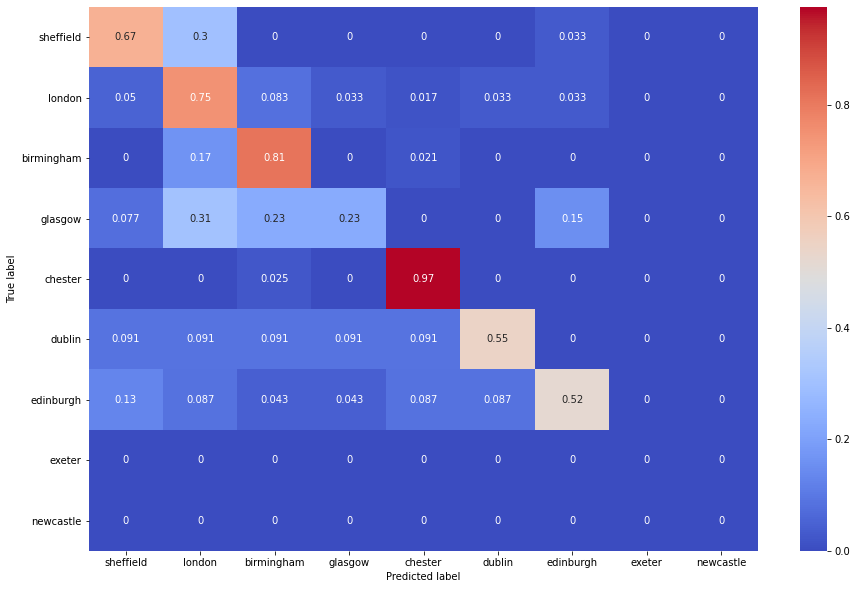

In [166]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns


plt.figure(figsize=(15, 10))
sns.heatmap(
    confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8], normalize='true'),
    annot=True,
    cmap='coolwarm',
    xticklabels=['sheffield', 'london', 'birmingham', 'glasgow', 'chester', 'dublin', 'edinburgh', 'exeter', 'newcastle'],
    yticklabels=['sheffield', 'london', 'birmingham', 'glasgow', 'chester', 'dublin', 'edinburgh', 'exeter', 'newcastle']
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks()


$$\texttt{accuracy}(y, \hat{y}) = \frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples}-1} 1(\hat{y}_i = y_i)$$

In [159]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.9850968703427719

$$\texttt{balanced-accuracy} = \frac{1}{2}\left( \frac{TP}{TP + FN} + \frac{TN}{TN + FP}\right )$$

In [160]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_true, y_pred)

0.9120675431189343

In [147]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93        23
           1       0.94      0.90      0.92        52
           2       0.92      0.95      0.93        37
           3       0.00      0.00      0.00         1
           4       0.75      1.00      0.86         3
           5       0.50      1.00      0.67         1
           6       0.33      0.50      0.40         2
           8       0.00      0.00      0.00         0

    accuracy                           0.90       119
   macro avg       0.56      0.65      0.59       119
weighted avg       0.92      0.90      0.91       119

